# 21 · SIFT en detalle: parámetros, efectos y visualización



## 1) Parámetros de `cv2.SIFT_create(...)`

```python
sift = cv2.SIFT_create(
    nfeatures=0,
    nOctaveLayers=3,
    contrastThreshold=0.04,
    edgeThreshold=10,
    sigma=1.6
)
```

**Explicación y buenas prácticas**
- `nfeatures`: máximo de puntos a retener (0 = sin límite duro).
- `nOctaveLayers`: capas por octava; más capas → mejor localización en escala (típico: 3).
- `contrastThreshold`: filtra puntos de bajo contraste; mayor → menos puntos, más estables.
- `edgeThreshold`: suprime respuestas dominadas por bordes largos; mayor → más permisivo.
- `sigma`: suavizado inicial en la octava base; controla el tamaño de estructuras capturadas.

SIFT detecta extremos de DoG en el espacio escala, refina posición, asigna orientación, y genera descriptores de 128D (flotantes), invariante a escala y rotación.

## 2) Carga de imagen

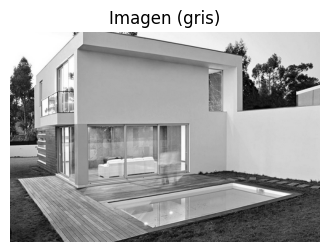

In [1]:
import cv2, numpy as np, matplotlib.pyplot as plt

IMG_PATH = r"C:\\Users\\20808\\Documents\\Repositorios\\Vision_en_Robotica\\imagenes\\casa.png"
img_bgr = cv2.imread(IMG_PATH, cv2.IMREAD_UNCHANGED)
if img_bgr is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen en {IMG_PATH}")
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
img_rgb  = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(4,4)); plt.imshow(img_gray, cmap='gray'); plt.title("Imagen (gris)"); plt.axis('off'); plt.show()


## 3) Utilidades para SIFT

In [2]:
def detect_sift(gray, nfeatures=0, nOctaveLayers=3, contrastThreshold=0.04, edgeThreshold=10, sigma=1.6):
    if not hasattr(cv2, 'SIFT_create'):
        raise RuntimeError('SIFT no está disponible en esta instalación de OpenCV (cv2.SIFT_create no existe).')
    sift = cv2.SIFT_create(nfeatures=nfeatures, nOctaveLayers=nOctaveLayers,
                           contrastThreshold=contrastThreshold, edgeThreshold=edgeThreshold, sigma=sigma)
    kps, des = sift.detectAndCompute(gray, None)
    return kps, des

def draw_keypoints_rgb(rgb, kps, rich=True):
    flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS if rich else 0
    vis = cv2.drawKeypoints(rgb, kps, None, color=(0,255,0), flags=flags)
    return vis

def kp_stats(kps):
    if not kps:
        return {}, None, None
    levels = {}
    angles = []
    sizes = []
    for kp in kps:
        levels[kp.octave] = levels.get(kp.octave, 0) + 1
        if kp.angle is not None and kp.angle >= 0:
            angles.append(kp.angle)
        sizes.append(kp.size)
    import numpy as np
    return levels, (np.array(angles) if len(angles)>0 else None), (np.array(sizes) if len(sizes)>0 else None)


## 4) Ejemplo base (parámetros prácticos)

Keypoints: 748 | Descriptor: (748, 128)


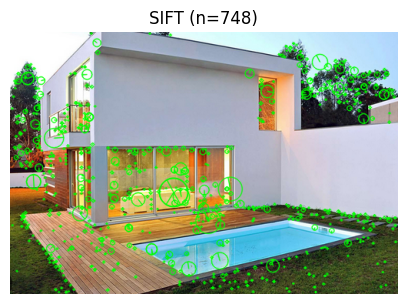

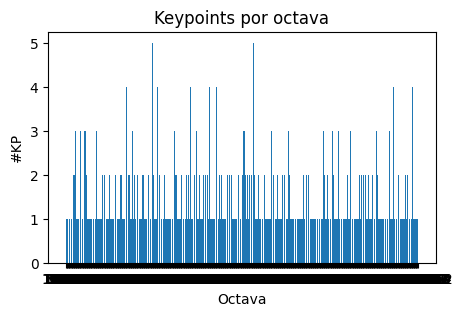

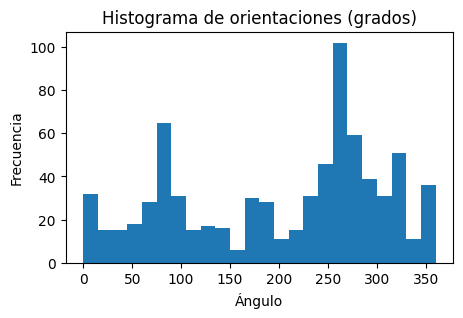

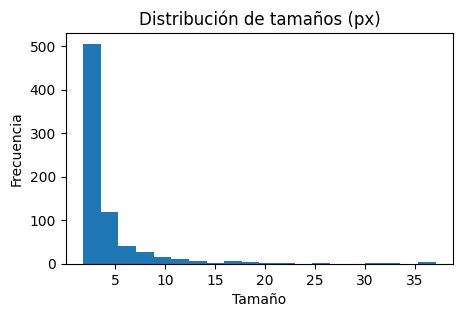

In [3]:
try:
    kps, des = detect_sift(img_gray, nfeatures=800, nOctaveLayers=3, contrastThreshold=0.04, edgeThreshold=10, sigma=1.6)
    print(f"Keypoints: {len(kps)} | Descriptor: {None if des is None else des.shape}")
    vis = draw_keypoints_rgb(img_rgb, kps, rich=True)
    plt.figure(figsize=(5,5)); plt.imshow(vis); plt.title(f"SIFT (n={len(kps)})"); plt.axis('off'); plt.show()

    levels, angles, sizes = kp_stats(kps)
    if levels:
        xs = sorted(levels.keys()); ys = [levels[x] for x in xs]
        plt.figure(figsize=(5,3)); plt.bar([str(x) for x in xs], ys)
        plt.title("Keypoints por octava"); plt.xlabel("Octava"); plt.ylabel("#KP"); plt.show()
    if angles is not None and angles.size>0:
        plt.figure(figsize=(5,3)); plt.hist(angles, bins=24, range=(0,360))
        plt.title("Histograma de orientaciones (grados)"); plt.xlabel("Ángulo"); plt.ylabel("Frecuencia"); plt.show()
    if sizes is not None and sizes.size>0:
        plt.figure(figsize=(5,3)); plt.hist(sizes, bins=20)
        plt.title("Distribución de tamaños (px)"); plt.xlabel("Tamaño"); plt.ylabel("Frecuencia"); plt.show()
except RuntimeError as e:
    print(e)


## 5) Interactivo: ajusta parámetros y observa el efecto

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

if hasattr(cv2, 'SIFT_create'):
    w_nfeatures = widgets.IntSlider(value=800, min=0, max=4000, step=50, description='nfeatures')
    w_layers    = widgets.IntSlider(value=3, min=1, max=6, step=1, description='nOctaveLayers')
    w_contrast  = widgets.FloatSlider(value=0.04, min=0.001, max=0.1, step=0.001, readout_format='.3f', description='contrastTh')
    w_edge      = widgets.IntSlider(value=10, min=1, max=30, step=1, description='edgeTh')
    w_sigma     = widgets.FloatSlider(value=1.6, min=0.6, max=3.0, step=0.1, readout_format='.1f', description='sigma')

    display(widgets.HBox([w_nfeatures, w_layers, w_contrast]))
    display(widgets.HBox([w_edge, w_sigma]))

    out = widgets.Output()
    display(out)

    def refresh(*args):
        with out:
            clear_output(wait=True)
            kps, des = detect_sift(img_gray,
                                   nfeatures=w_nfeatures.value,
                                   nOctaveLayers=w_layers.value,
                                   contrastThreshold=w_contrast.value,
                                   edgeThreshold=w_edge.value,
                                   sigma=w_sigma.value)
            vis = draw_keypoints_rgb(img_rgb, kps, rich=True)
            print(f"Keypoints: {len(kps)} | Descriptor: {None if des is None else des.shape}")
            plt.figure(figsize=(5,5)); plt.imshow(vis); plt.title("SIFT (parámetros actuales)"); plt.axis('off'); plt.show()

            levels, angles, sizes = kp_stats(kps)
            if levels:
                xs = sorted(levels.keys()); ys = [levels[x] for x in xs]
                plt.figure(figsize=(5,3)); plt.bar([str(x) for x in xs], ys)
                plt.title("Keypoints por octava"); plt.xlabel("Octava"); plt.ylabel("#KP"); plt.show()
            if angles is not None and angles.size>0:
                plt.figure(figsize=(5,3)); plt.hist(angles, bins=24, range=(0,360))
                plt.title("Histograma de orientaciones (grados)"); plt.xlabel("Ángulo"); plt.ylabel("Frecuencia"); plt.show()
            if sizes is not None and sizes.size>0:
                plt.figure(figsize=(5,3)); plt.hist(sizes, bins=20)
                plt.title("Distribución de tamaños (px)"); plt.xlabel("Tamaño"); plt.ylabel("Frecuencia"); plt.show()

    for w in [w_nfeatures, w_layers, w_contrast, w_edge, w_sigma]:
        w.observe(refresh, names='value')
    refresh()
else:
    print("SIFT no está disponible en tu instalación de OpenCV (cv2.SIFT_create no existe).")


Output()

## 6) Guía práctica (robótica)

- **Tiempo real moderado**: limita `nfeatures` (p.ej. 500–1500) y ajusta `contrastThreshold` para evitar puntos débiles.
- **Escalas variadas**: sube `nOctaveLayers` (3–5) para mejor precisión en escala.
- **Iluminación complicada**: mantén `contrastThreshold` medio/alto y `edgeThreshold` en torno a 10–15.
- **Escenas con bordes dominantes**: sube `edgeThreshold` si se pierden puntos válidos; bájalo si aparecen muchos en bordes largos.
- **Estructuras muy finas**: reduce ligeramente `sigma` para captar detalles pequeños (con cuidado del ruido).